There appear to be some cases where a visit in the simulated LSST observation database does not get counted when spatial metrics are performed.

This arises because the visit is not represented in some cases of the spatial healpixel slicer. 
This notebook shows an example of this

In [1]:
%matplotlib notebook

In [2]:
%matplotlib inline

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import sqlite3


In [4]:
# select the survey simulation
opsdb = "baseline_v3.3_10yrs.db"

# range of nights to investigate (year 1 of survey)
night_max = 365

In [5]:
class return_observationId(maf.metrics.BaseMetric):
    """
    Return the list of all visit observationId's in a dataSlice 
    """
    def __init__(self, col='observationId', metric_dtype="object", **kwargs):
        super().__init__(col=col, metric_dtype=metric_dtype, **kwargs)
        self.idCol = col
    def run(self, dataSlice, slice_point=None):
        return dataSlice[self.idCol]

In [6]:
def run_return_observationId(data_in, nside=32, id_col='observationId',
                        **kwargs):
    """
    Get all observationId's of every visit that appears in the healpixel dataSlice
    """
    
    slicer = maf.slicers.HealpixSlicer(nside=nside, verbose=False)
    metric = return_observationId()
    sql=None
    bundle = maf.MetricBundle(metric, slicer, sql)
    mbg = maf.MetricBundleGroup([bundle], None, save_early=False,
                                verbose=False)
    mbg.run_current(None, sim_data=data_in)
    
    # we retrieve an array with the id_col (observationId) of every single visit in each dataSlice
    obsIds = np.concatenate(bundle.metric_values.data[~bundle.metric_values.mask])

    return obsIds

In [7]:
# load the visit database
data = maf.get_sim_data(opsdb, None, None,
                      full_sql_query='select * from observations where night <= {};'.format(night_max))

# convert to dataframe
df = pd.DataFrame(data)

# write the dataframe to recarray
data = df.to_records(index=False)

# Check the presence of each visit in the nside = 256 healpixel map

In [8]:
obsId_in_slice_256 = run_return_observationId(data, nside=256)
obsId_slice_mask_256 = np.isin(df["observationId"],obsId_in_slice_256)
df_in_slice_256 = df[obsId_slice_mask_256]
df_not_slice_256 = df[~obsId_slice_mask_256]
print(len(df),len(df_in_slice_256),len(df_not_slice_256),len(df_in_slice_256)+len(df_not_slice_256))

239938 239938 0 239938


At a resolution of nside = 256 all visits are represented by at least one healpixel

# Now check lower resolution nside = 32

In [9]:
obsId_in_slice_32 = np.unique(run_return_observationId(data, nside=32))
obsId_slice_mask_32 = np.isin(df["observationId"],obsId_in_slice_32)
df_in_slice_32 = df[obsId_slice_mask_32]
df_not_slice_32 = df[~obsId_slice_mask_32]
print(len(df),len(df_in_slice_32),len(df_not_slice_32),len(df_in_slice_32)+len(df_not_slice_32))

239938 239393 545 239938


In [10]:
df_not_slice_32

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,sunAz,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id
377,377,188.135027,-49.373400,60796.176965,60796.219252,30.0,u,351.997999,351.997999,1,...,202.440152,38.276896,15.030744,86.672712,28.762438,118.595949,137.786683,25.895616,-140.385818,0
427,427,188.135027,-49.373400,60796.199712,60796.219252,30.0,g,351.997999,351.997999,2,...,171.794208,38.298624,15.037640,87.127923,28.723562,118.279349,137.782492,26.101494,-139.740608,0
1028,1028,164.528041,-7.016988,60796.996331,60797.025738,30.0,u,131.864273,131.864273,1,...,274.613986,39.060303,15.277767,99.927379,28.806457,71.689506,125.996510,31.899720,42.043076,0
1078,1078,164.528041,-7.016988,60797.020237,60797.025738,30.0,g,131.864273,131.864273,2,...,270.460434,39.083182,15.284932,100.218338,28.727488,71.422684,125.974160,32.028921,36.195403,0
1498,1498,194.263609,-54.846098,60797.212410,60797.245236,30.0,g,299.797348,299.797348,2,...,157.385637,39.267143,15.342438,103.216712,27.995964,113.146399,136.017043,33.401218,-103.519415,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238143,238143,174.618596,10.911055,61160.062840,61160.067330,30.0,y,181.962848,181.962848,2,...,261.225388,36.969243,14.610858,198.126233,-10.998056,32.028878,130.878776,89.600698,38.181830,0
239552,239552,276.688263,-58.548282,61161.246320,61161.287509,30.0,y,49.018682,49.018682,2,...,127.640199,38.096939,14.973205,211.016918,-17.069326,62.877638,118.887753,96.044569,-116.708008,0
239602,239602,276.688263,-58.548282,61161.268896,61161.287509,30.0,y,49.018682,49.018682,2,...,115.297727,38.118481,14.980062,211.182684,-17.159580,62.716708,118.904240,96.104820,-115.127315,0
239676,239676,289.039086,-18.915909,61161.304109,61161.331531,30.0,i,102.925502,102.925502,2,...,103.758070,38.152083,14.990752,211.460028,-17.291855,73.103794,112.523437,96.207266,-191.688268,0


At the lower resolution some visits appear to not have a corresponding healpixel

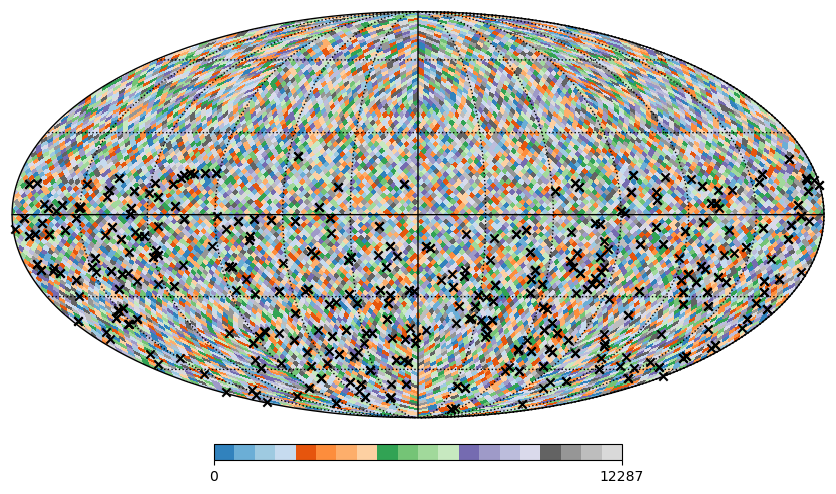

In [11]:
# plot the positions of the missing visits onto the healpixel skymap
hpids = np.arange(hp.nside2npix(32))
np.random.shuffle(hpids)
hp.mollview(hpids,cmap="tab20c",title=None)
hp.graticule()
# plot scatter of missing fields on top
ax = plt.gca()
hp.projscatter(df_not_slice_32["fieldRA"],df_not_slice_32["fieldDec"],
               marker = "x",c = "k", lonlat = True) # use healpy package: https://healpy.readthedocs.io/en/latest/healpy_visu.html

plt.show()